In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets,transforms
from torch.utils.data import DataLoader

import typing
import matplotlib.pyplot as plt

import random

In [12]:
batch_size = 128
learning_rate = 0.001
num_epochs = 5

In [4]:
def get_device() -> str:
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_dataset(bach_size:int) -> typing.Tuple[DataLoader,DataLoader]:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))
    ])

    train_dataset = datasets.MNIST(
        root="./data",
        train = True,
        transform=transform,
        download=True)
    
    test_dataset = datasets.MNIST(
        root="./data",
        train = False,
        transform=transform,
        download=True)
    
    train_loader = DataLoader(
        dataset = train_dataset,
        batch_size = bach_size,
        shuffle = True
    )

    test_loader = DataLoader(
        dataset = test_dataset,
        batch_size = bach_size,
        shuffle = True
    )

    return (train_loader,test_loader,train_dataset,test_dataset)

In [5]:
def get_random_image_loader(dataloader:DataLoader)-> None:
    
    random_batch = torch.randint(0,len(dataloader),(1,)).item()
    print(random_batch)
    dataloader_iter = iter(dataloader)
    for _ in range(random_batch):
        next(dataloader_iter)
        
    images,labels = next(dataloader_iter)
    random_image = torch.randint(0,len(images),(1,)).item()
    image = images[random_image]
    label = labels[random_image]
    image = image * 0.5 + 0.5 
    image = image.permute(1, 2, 0)
    plt.imshow(image.squeeze(), cmap="gray")  
    plt.title(f"Etiqueta: {label.item()}")
    plt.axis("off")
    plt.show() 

In [6]:
device = get_device()
train_loader,test_loader,train_dataset,test_dataset = get_dataset(bach_size=batch_size)

566


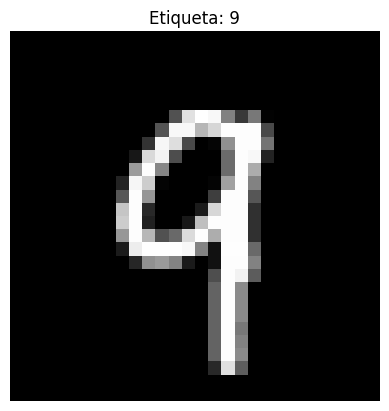

In [7]:
get_random_image_loader(train_loader)

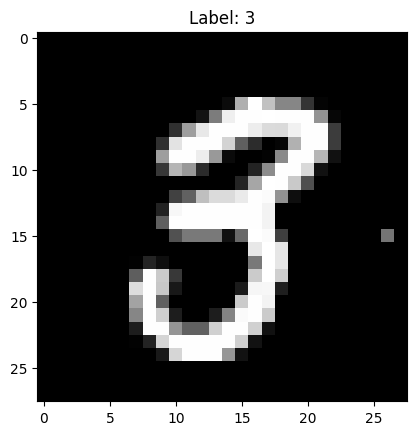

In [8]:
def get_random_image_dataset(dataset:datasets):
    idx = random.randint(0,len(dataset)-1)
    plt.imshow(dataset.data[idx],cmap='gray')
    plt.title(f"Label: {dataset.targets[idx].item()}")

get_random_image_dataset(train_dataset)

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64*7*7,128,128)
        self.fc2 = nn.Linear(128,10)
    
    def forward(self,x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1,64*7*7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = SimpleCNN().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()

    for images,labels in train_loader:
        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoca {epoch+1}, Perdida {running_loss/len(train_loader):.4f} ")

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images,labels in test_loader:
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        _,predicted = torch.max(outputs,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100*correct / total
    print(f"Precision en el conjunto de prueba: {accuracy:.2f}%")

Epoca 1, Perdida 0.1512 
Epoca 2, Perdida 0.0442 
Epoca 3, Perdida 0.0293 
Epoca 4, Perdida 0.0226 
Epoca 5, Perdida 0.0164 
Epoca 6, Perdida 0.0141 
Epoca 7, Perdida 0.0108 
Epoca 8, Perdida 0.0092 
Epoca 9, Perdida 0.0078 
Epoca 10, Perdida 0.0073 
Precision en el conjunto de prueba: 99.30%
